In [217]:

import random
import json
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#word2vec
import gensim
from gensim.models import Word2Vec

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torchutils as tu

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from collections import Counter
from dataclasses import dataclass

from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryConfusionMatrix

import sys
sys.path.append("../src/")
from ltsm_helper import tokenize_text

JSONDecodeError: Expecting ':' delimiter: line 1 column 566745 (char 566744)

In [134]:
WORD_FREQ = 20
EMBEDDING_DIM = 100
HIDDEN_SIZE = 128
ATTENTION_SIZE = 32
SEQ_LEN = 128
TEST_SIZE = 0.1
BATCH_SIZE = 1024
DEVICE = 'cuda'
EPOCHS = 20

In [14]:
@dataclass
class ConfigRNN:
    vocab_size: int
    batch_size: int
    device: str
    n_layers: int
    embedding_dim: int
    hidden_size: int
    seq_len: int
    bidirectional: bool
    attention_size: int
    dropout: float
    output: int

In [15]:
class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim):
        super(BahdanauAttention, self).__init__()
        # Linear layers to transform encoder outputs and decoder hidden state
        self.W1 = nn.Linear(encoder_dim, decoder_dim)
        self.W2 = nn.Linear(decoder_dim, decoder_dim)
        # v is a learnable parameter vector to compute attention scores
        self.v = nn.Linear(decoder_dim, 1, bias=False)

    def forward(self,encoder_outputs, hidden):
        # hidden: (batch_size, decoder_dim)
        # encoder_outputs: (batch_size, seq_len, encoder_dim)
        seq_len = encoder_outputs.size(1)

        # Repeat hidden state seq_len times for addition
        hidden_with_time_axis = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # score shape: (batch_size, seq_len, decoder_dim)
        score = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden_with_time_axis))
        # attention_weights shape: (batch_size, seq_len, 1)
        attention_weights = torch.softmax(self.v(score), dim=1)

        # context_vector: weighted sum of encoder outputs
        context_vector = torch.sum(attention_weights * encoder_outputs, dim=1)
        # attention_weights: (batch_size, seq_len)
        return attention_weights.squeeze(-1), context_vector

In [3]:
df = pd.read_csv('../data/cleaned_df.csv')
df.drop(columns=['Unnamed: 0', 'review_id'], inplace=True)

In [4]:
df.head()

,category,title,content,sentiment,source_url,clean_content
0,Поликлиники стоматологические,Классный мастер,Огромное спасибо за чудесное удаление двух зуб...,positive,http://www.spr.ru/forum_vyvod.php?id_tema=2727539,огромный спасибо чудесный удаление зуб мудрост...
1,Поликлиники стоматологические,Замечательный врач,Хочу выразить особую благодарность замечательн...,positive,http://www.spr.ru/forum_vyvod.php?id_tema=2302877,хотеть выразить особый благодарность замечател...
2,Поликлиники стоматологические,Благодарность работникам рентгена,Добрый вечер! Хотелось бы поблагодарить сотруд...,positive,http://www.spr.ru/forum_vyvod.php?id_tema=2815031,добрый вечер хотеться поблагодарить сотрудник ...
3,Поликлиники стоматологические,Доктор Рабинович,Женщины советского образца в регистратуре не и...,negative,http://www.spr.ru/forum_vyvod.php?id_tema=3443161,женщина советский образец регистратура не имет...
4,Поликлиники стоматологические,Есть кому сказать спасибо,У меня с детства очень плохие зубы (тонкая и х...,positive,http://www.spr.ru/forum_vyvod.php?id_tema=2592430,детство очень плохой зуб тонкий хрупкий эмаль ...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70597 entries, 0 to 70596
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category       70597 non-null  object
 1   title          70597 non-null  object
 2   content        70597 non-null  object
 3   sentiment      70597 non-null  object
 4   source_url     70597 non-null  object
 5   clean_content  70597 non-null  object
dtypes: object(6)
memory usage: 3.2+ MB


In [6]:
def get_words_by_freq(words, n):
    return list(filter(lambda x: x[1] > n, words))

In [19]:
def padding(reviews, seq_len):
    features = np.zeros((len(reviews), seq_len))
    for i, review in enumerate(reviews):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[:seq_len]
        features[i, :] = np.array(new)
        
    return features

In [104]:
def train_attention_lstm(
    epochs: int, 
    model: torch.nn.Module, 
    train_loader: DataLoader,
    valid_loader: DataLoader, 
    optimizer, 
    criterion, 
    metric,
    rnn_conf = None
    ) -> tuple: 
    
    best_val_loss = float('inf')
    epoch_train_losses = []
    epoch_valid_losses = []
    epoch_train_metric = []
    epoch_valid_metric = []
    time_start = time.time()
    
    
    if not rnn_conf:
        device = 'cpu'
    else: 
        device = rnn_conf.device

    for epoch in range(epochs):
        bacth_losses = []
        batch_metric = []
        model.train()
        model.to(device)
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(torch.long).to(device), labels.to(device)   

            output, _ = model(inputs)
            loss = criterion(output, labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            bacth_losses.append(loss.item())
            batch_metric.append(metric(output,labels).item())
        epoch_train_losses.append(np.mean(bacth_losses))
        epoch_train_metric.append(np.mean(batch_metric))
        bacth_losses = []
        batch_metric = []
        model.eval()
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(torch.long).to(device), labels.to(device)
            with torch.no_grad():
                output, _ = model(inputs)
            loss = criterion(output, labels.float())
            bacth_losses.append(loss.item())
            batch_metric.append(metric(output,labels).item())
        epoch_valid_losses.append(np.mean(bacth_losses))
        epoch_valid_metric.append(np.mean(batch_metric))


        print(f'Epoch {epoch+1}') 
        print(f'train_loss : {epoch_train_losses[-1]:.4f} val_loss : {epoch_valid_losses[-1]:.4f}')
        print(f'train_accuracy : {epoch_train_metric[-1]:.2f} val_accuracy : {epoch_valid_metric[-1]:.2f}')
            
        print(25*'==')
        training_time = time.time() - time_start
        
        
        if np.mean(bacth_losses) < best_val_loss:
            best_val_loss = np.mean(bacth_losses)
            torch.save(model, f'bert_best_{best_val_loss:.2f}.pt')
            torch.save(model.state_dict(), f'bert_best_{best_val_loss:.2f}.pth')
        
        
    return (epoch_train_losses, epoch_valid_losses, epoch_train_metric, epoch_valid_metric, training_time)

In [7]:
corpus = [word for text in df['clean_content'] for word in text.split()]
sorted_words = Counter(corpus).most_common()
sorted_words = get_words_by_freq(sorted_words, WORD_FREQ)

In [8]:
vocab2int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

In [220]:
f = open('vocab2int.json', 'w')
json.dump(vocab2int, f, indent=4)

In [219]:
len(vocab2int)

9766

In [9]:
reviews_int = []
for text in df['clean_content']:
    r = [vocab2int[word] for word in text.split() if vocab2int.get(word)]
    reviews_int.append(r)

In [10]:
w2v_input = []
for text in df['clean_content']:
    filtered_text = []
    for word in text.split():
        if vocab2int.get(word):
            filtered_text.append(word)
        w2v_input.append(filtered_text)

In [11]:
VOCAB_SIZE = len(vocab2int) + 1

In [204]:
VOCAB_SIZE

9767

In [12]:
wv = Word2Vec(
    vector_size=EMBEDDING_DIM
)
wv.build_vocab(w2v_input)

In [13]:
wv.train(
    corpus_iterable=w2v_input,
    total_examples=wv.corpus_count,
    epochs=EPOCHS
)

(7814460162, 8807032020)

In [169]:
wv.save('word2vec_model')

In [17]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, i in vocab2int.items():
    try:
        embedding_vector = wv.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError as e:
        print(f'{e}: word: {word}')
        pass
    
embedding_layer = nn.Embedding.from_pretrained(
    torch.FloatTensor(embedding_matrix)
)

In [20]:
padded = padding(reviews_int, seq_len=SEQ_LEN)

In [ ]:
# encoder = {
#     'negative': 0,
#     'positive': 1
# }
# X, y = np.array(padded), df.loc[:,'sentiment'].map(encoder)
# X_train, X_valid, y_train, y_valid = train_test_split(
#     X,y, test_size=TEST_SIZE, random_state=1
# )

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(
    np.array(padded),
    pd.get_dummies(
        df['sentiment'],
        drop_first=True
    ).to_numpy().astype(int), test_size=TEST_SIZE, random_state=1
)

In [45]:
train_data = TensorDataset(
    torch.from_numpy(X_train), torch.from_numpy(y_train)
)
valid_data = TensorDataset(
    torch.from_numpy(X_valid), torch.from_numpy(y_valid)
)
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE)

In [46]:
dataiter = iter(train_loader)
x_train_batch, y_train_batch = next(dataiter)
x_train_batch.shape

torch.Size([1024, 128])

In [139]:
net_config = ConfigRNN(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    device=DEVICE,
    n_layers=3,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    seq_len=SEQ_LEN,
    bidirectional=True,
    attention_size=ATTENTION_SIZE,
    dropout=0.4,
    output=1
)

In [29]:
test_config = ConfigRNN(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    device=DEVICE,
    n_layers=1,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    seq_len=SEQ_LEN,
    bidirectional=False,
    attention_size=ATTENTION_SIZE,
    dropout=0.0,
    output=1
)

In [30]:
class LSTMClassifier(nn.Module):
    def __init__(
        self,
        config=net_config
    ):
        super(LSTMClassifier, self).__init__()
        self.embedding = embedding_layer
        self.hidden_size = config.hidden_size
        self.n_layers = config.n_layers
        self.bidirectional = config.bidirectional
        self.num_directions = 2 if config.bidirectional else 1

        # LSTM layer
        self.lstm = nn.LSTM(
            config.embedding_dim,
            config.hidden_size,
            num_layers=config.n_layers,
            bidirectional=config.bidirectional,
            batch_first=True,
            dropout=config.dropout if config.n_layers > 1 else 0,
        )

        # Attention layer
        self.attention = BahdanauAttention(
            encoder_dim=config.hidden_size * self.num_directions,
            decoder_dim=config.hidden_size * self.num_directions,
        )

        # Final fully connected layer for classification
        self.fc = nn.Linear(config.hidden_size * self.num_directions, config.output)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, input_sequences, lengths=None):
        # input_sequences: (batch_size, seq_len)
        # lengths: list or tensor of actual sequence lengths (for packing)
        embedded = self.embedding(input_sequences)
        embedded = self.dropout(embedded)

        # Pack sequences if lengths provided
        if lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(
                embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
            )
            packed_outputs, (hidden, cell) = self.lstm(packed)
            # Unpack
            encoder_outputs, _ = nn.utils.rnn.pad_packed_sequence(
                packed_outputs, batch_first=True
            )
        else:
            encoder_outputs, (hidden, cell) = self.lstm(embedded)

        # Concatenate the final forward and backward hidden states
        if self.bidirectional:
            # hidden: (num_layers*2, batch, hidden_size)
            forward_hidden = hidden[-2]
            backward_hidden = hidden[-1]
            final_hidden = torch.cat((forward_hidden, backward_hidden), dim=1)
        else:
            final_hidden = hidden[-1]

        # Apply Bahdanau attention
        attn_weights, context_vector = self.attention(
            encoder_outputs, final_hidden
        )

        # Classifier
        logits = self.fc(self.dropout(context_vector))
        return logits, attn_weights

In [135]:
attention = BahdanauAttention(test_config.hidden_size, test_config.hidden_size)
tu.get_model_summary(attention, torch.randn(BATCH_SIZE, SEQ_LEN, HIDDEN_SIZE), torch.randn(BATCH_SIZE, HIDDEN_SIZE))

Layer     Kernel          Output        Params           FLOPs
0_W1    [128, 128]   [1024, 128, 128]   16,512   4,278,190,080
1_W2    [128, 128]   [1024, 128, 128]   16,512   4,278,190,080
2_v       [128, 1]     [1024, 128, 1]      128      33,423,360
Total params: 33,152
Trainable params: 33,152
Non-trainable params: 0
Total FLOPs: 8,589,803,520 / 8.59 GFLOPs
--------------------------------------------------------------
Input size (MB): 64.50
Forward/backward pass size (MB): 257.00
Params size (MB): 0.13
Estimated Total Size (MB): 321.63


In [136]:
model_concat = LSTMClassifier().to(DEVICE)
tu.get_model_summary(model_concat, x_train_batch.to(torch.long).to(DEVICE))

Layer                     Kernel           Output         Params               FLOPs
0_embedding             [100, 9767]   [1024, 128, 100]     976,700           131,072
1_dropout                         -   [1024, 128, 100]           0                 0
2_lstm                            -   [1024, 128, 256]   1,026,048   782,959,116,288
3_attention.Linear_W1    [256, 256]   [1024, 128, 256]      65,792    17,146,314,752
4_attention.Linear_W2    [256, 256]   [1024, 128, 256]      65,792    17,146,314,752
5_attention.Linear_v       [256, 1]     [1024, 128, 1]         256        66,977,792
6_dropout                         -        [1024, 256]           0                 0
7_fc                       [256, 1]          [1024, 1]         257           523,264
Total params: 2,134,845
Trainable params: 1,158,145
Non-trainable params: 976,700
Total FLOPs: 817,319,377,920 / 817.32 GFLOPs
------------------------------------------------------------------------------------
Input size (MB): 1.00
F

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer_concat = torch.optim.Adam(model_concat.parameters(), lr=1e-3)
metric = BinaryAccuracy().to(DEVICE)

In [138]:
train_losses, val_losses, train_metric, val_metric, rnn_time = train_attention_lstm(
    EPOCHS, model_concat, train_loader, valid_loader, optimizer_concat, criterion, metric
)

Epoch 1
train_loss : 0.3552 val_loss : 0.1948
train_accuracy : 0.85 val_accuracy : 0.93
Epoch 2
train_loss : 0.1933 val_loss : 0.2108
train_accuracy : 0.93 val_accuracy : 0.92
Epoch 3
train_loss : 0.1735 val_loss : 0.1747
train_accuracy : 0.93 val_accuracy : 0.93
Epoch 4
train_loss : 0.1657 val_loss : 0.2112
train_accuracy : 0.94 val_accuracy : 0.92
Epoch 5
train_loss : 0.1576 val_loss : 0.1601
train_accuracy : 0.94 val_accuracy : 0.94
Epoch 6
train_loss : 0.1517 val_loss : 0.1496
train_accuracy : 0.94 val_accuracy : 0.94
Epoch 7
train_loss : 0.1465 val_loss : 0.1553
train_accuracy : 0.95 val_accuracy : 0.94
Epoch 8
train_loss : 0.1391 val_loss : 0.2527
train_accuracy : 0.95 val_accuracy : 0.90
Epoch 9
train_loss : 0.1415 val_loss : 0.1606
train_accuracy : 0.95 val_accuracy : 0.94
Epoch 10
train_loss : 0.1323 val_loss : 0.1851
train_accuracy : 0.95 val_accuracy : 0.93
Epoch 11
train_loss : 0.1288 val_loss : 0.1548
train_accuracy : 0.95 val_accuracy : 0.94
Epoch 12
train_loss : 0.1267 v

In [ ]:
# torch.save(model_concat, 'lstm_best.pt')
# torch.save(model_concat.state_dict(), 'lstm_best:.pth')

In [140]:
model_concat.load_state_dict(torch.load('bert_best_0.15.pth'))
model_concat.to(DEVICE)

<All keys matched successfully>

In [164]:
model_concat

LSTMClassifier(
  (embedding): Embedding(9767, 100)
  (lstm): LSTM(100, 128, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (attention): BahdanauAttention(
    (W1): Linear(in_features=256, out_features=256, bias=True)
    (W2): Linear(in_features=256, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [165]:
model_concat.eval()

scripted = torch.jit.script(model_concat)
torch.jit.save(scripted, 'script_lstm.pt')

RuntimeError: strides() called on an undefined Tensor

In [145]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [196]:
acc = []
f1 = []
conf = []

metric_acc = BinaryAccuracy().to(DEVICE)
metric_f1 = BinaryF1Score().to(DEVICE)
metric_conf = BinaryConfusionMatrix().to(DEVICE)


for inputs, labels in valid_loader:
    inputs, labels = inputs.to(torch.long).to(DEVICE), labels.to(DEVICE)     
    with torch.inference_mode():
        output, _ = model_concat(inputs)
        acc.append(metric_acc(output,labels).item())
        f1.append(metric_f1(output,labels).item())
        conf.append(metric_conf(output,labels))

In [197]:
np.mean(acc), np.mean(f1)

(0.9448546086038861, 0.9521312117576599)

In [198]:
conf = [t.cpu() for t in conf]
conf = np.array(conf)
conf

14

In [201]:
conf = np.mean(conf, axis=0)
conf = np.round(conf).astype(int)
conf

array([[400,  18],
       [ 37, 553]])

In [202]:
decoder = {
    0: 'negative',
    1: 'positive'
}


<Axes: >

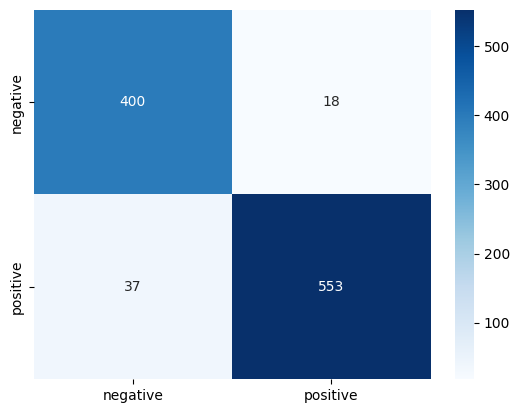

In [203]:
class_labels = [decoder[i] for i in sorted(decoder.keys())]

sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)

In [160]:
preds = np.where(np.array(preds) > 0.5, 1, 0)
preds

array([0, 0, 0, ..., 0, 0, 0])

In [162]:
accuracy_score(y_valid, preds)

0.49178470254957507

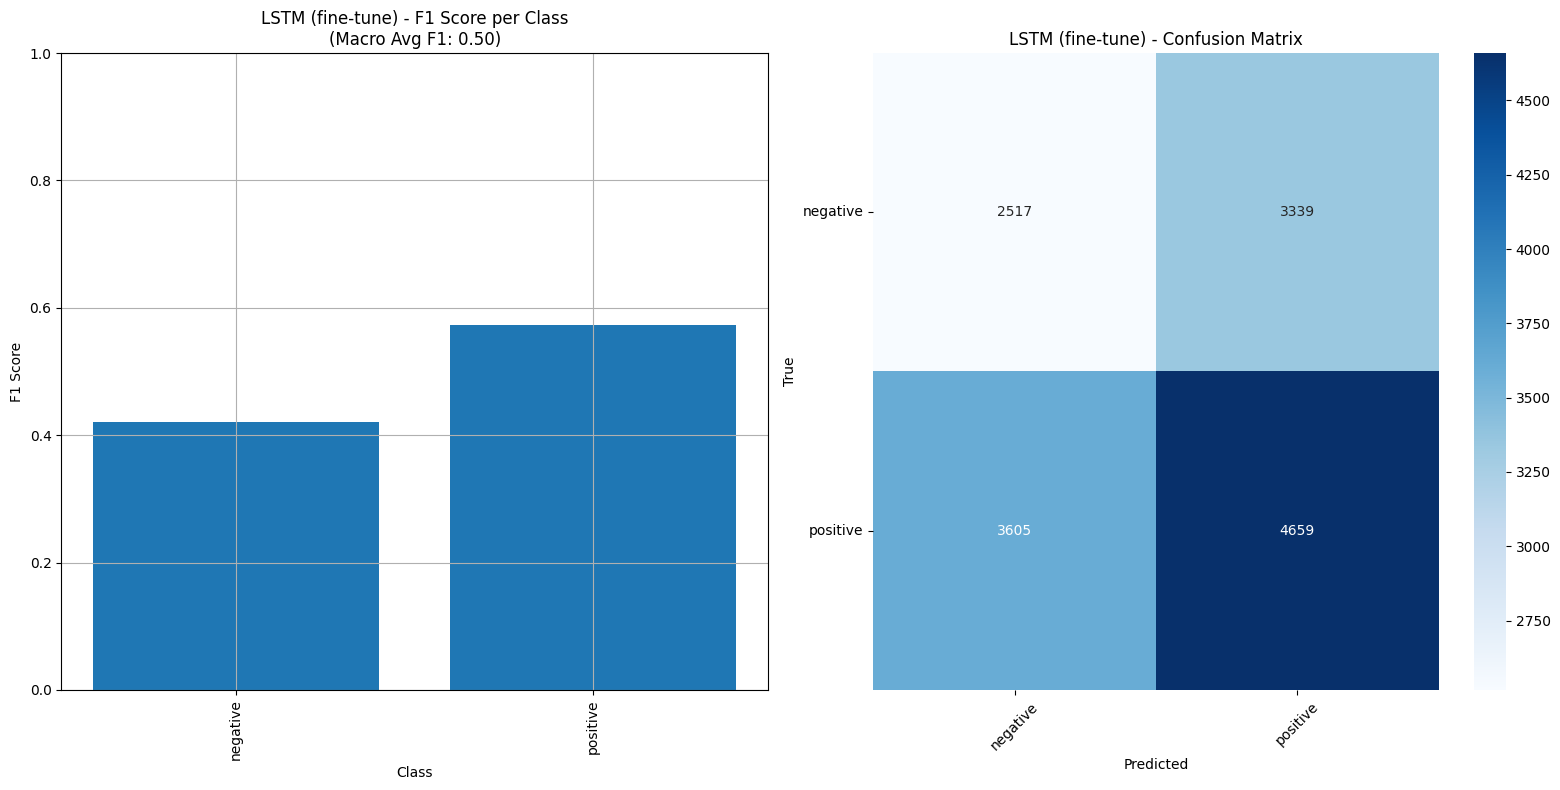

In [155]:
models = {
    "LSTM (fine-tune)": model_concat,
}

# Prepare plots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes = axes.ravel()

# Class labels (human-readable)
class_labels = [decoder[i] for i in sorted(decoder.keys())]

for idx, (name, model) in enumerate(models.items()):
    # Predict class labels
    y_test = y_valid
    y_pred = preds

    # Compute macro F1-score and per-class F1
    f1 = f1_score(y_test, y_pred, average='macro')
    f1_per_class = f1_score(y_test, y_pred, average=None)

    # Bar chart for per-class F1-scores
    axes[idx].bar(np.arange(len(f1_per_class)), f1_per_class, tick_label=class_labels)
    axes[idx].set_title(f'{name} - F1 Score per Class\n(Macro Avg F1: {f1:.2f})')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('F1 Score')
    axes[idx].set_ylim(0, 1)
    axes[idx].tick_params(axis='x', rotation=90)
    axes[idx].grid(True)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx + 1],
                xticklabels=class_labels, yticklabels=class_labels)
    axes[idx + 1].set_title(f'{name} - Confusion Matrix')
    axes[idx + 1].set_xlabel('Predicted')
    axes[idx + 1].set_ylabel('True')
    axes[idx + 1].tick_params(axis='x', rotation=45)
    axes[idx + 1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

In [87]:
probs

array([1, 0, 1, ..., 0, 0, 0])

In [206]:
loaded_model = torch.load("bert_best_0.15.pt", map_location=DEVICE, weights_only=False)
loaded_model.eval()

LSTMClassifier(
  (embedding): Embedding(9767, 100)
  (lstm): LSTM(100, 128, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (attention): BahdanauAttention(
    (W1): Linear(in_features=256, out_features=256, bias=True)
    (W2): Linear(in_features=256, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=False)
  )
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [211]:
df['clean_content'][0]

'огромный спасибо чудесный удаление зуб мудрость мгновение доктор матвеев профессионал большой буква бояться страшно весь занять реально секунда согласиться удаление сразу второй зуб боль страх очень рекомендовать'